In [1]:
import glob
import cv2
import math 
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import json
import datetime
import matplotlib.image as mpimg
import random
import time


%matplotlib inline
import pandas as pd
import numpy as np
np.random.bit_generator = np.random._bit_generator

from tensorflow.keras.preprocessing import image
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten,MaxPooling2D, concatenate, UpSampling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Model,load_model
#from keras_segmentation.models.model_utils import get_segmentation_mode
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
#from tensorflow.contrib import distributions

# from tensorflow.keras.utils import np_utils
from skimage.transform import resize
from datetime import datetime
from mpl_toolkits.mplot3d import Axes3D
from imgaug import augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

In [2]:
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.gpu_options.per_process_gpu_memory_fraction = 0.7
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



In [3]:
def get_img_name(path):
    names = glob.glob(f"{path}*")
    names.sort()
    return names

def img_process(img):
    img = cv2.resize(img, (IMG_WIDTH,IMG_HEIGHT)) #640x480, 320x240
    return img

def show_seg_on_img(img, mask, alpha=0.5):
    #img = img.astype(np.float64)*255
    #img = cv2.normalize(img, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)
    #mask = mask.astype(np.float64)*255
    #mask = cv2.normalize(mask, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)
    
    img_mask = cv2.addWeighted(mask, alpha, img, 0.5, 0)
    return img_mask 

def compare_img(img1, img2, title1 = 'Image 1', title2 = 'Image 2'):
    #img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    #img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    
    fig = plt.figure(figsize=(16, 12))
    a = fig.add_subplot(1,2,1)
    imgplot = plt.imshow(img1)
    a.set_title(title1)

    a = fig.add_subplot(1, 2, 2)
    imgplot = plt.imshow(img2)

    
def predictions_and_uncetrenty(model, T, img):
    
    # shape: (T, (H, W), C)
    predictions = np.array([model.predict(img) for _ in range(T)])
    
    # shape: ((H, W), C)
    prediction_probabilities = np.mean(predictions, axis=tuple(range(img.ndim-2)))
   
    # shape: (H, W)
    #prediction_variances = np.apply_along_axis(predictive_entropy, axis=2, arr=prediction_probabilities)
    prediction_std = np.std(predictions, axis=tuple(range(img.ndim-2)))
    prediction_mask = (prediction_probabilities==prediction_probabilities.max(axis=2, keepdims=1)).astype(np.uint8)
    prediction_std = prediction_std * prediction_mask
    prediction_std = np.amax(prediction_std, axis=2)
    
    prediction_mean = prediction_probabilities * prediction_mask
    prediction_mean = np.amax(prediction_mean, axis=2)
    return prediction_mask, prediction_mean ,prediction_std

'''
If we are not using image augmentation we need to reduce the channels.
'''
def labels_to_maskes_reduce(img_label, color_id_map, num_channels):
    num_objects = len(color_id_map.keys())
    
    height = img_label.shape[0]
    width = img_label.shape[1]

    channels = np.zeros((height, width, num_channels), dtype=np.uint8)
    
    for key, value in color_id_map.items():
        mask = (img_label == value[1]).all(-1)

        channels[..., value[0]] = np.logical_or(channels[:,:, value[0]], mask)


    return channels

def maskes_to_labels(maskes):
    #denne maa muligens fjernes
    maskes = (maskes==maskes.max(axis=2, keepdims=1)).astype(np.uint8)
    labels = np.zeros((maskes.shape[0], maskes.shape[1], 3), dtype=np.uint8)
        
    for key, value in classes_cc.items():
        mask = maskes[..., key]
        labels = labels + mask[..., None] * value
    
    return labels 

def predictions_and_uncetrenty(model, T, img):
    
    # shape: (T, (H, W), C)
    predictions = np.array([model.predict(img) for _ in range(T)])
    
    # shape: ((H, W), C)
    prediction_probabilities = np.mean(predictions, axis=tuple(range(img.ndim-2)))
   
    # shape: (H, W)
    #prediction_variances = np.apply_along_axis(predictive_entropy, axis=2, arr=prediction_probabilities)
    prediction_std = np.std(predictions, axis=tuple(range(img.ndim-2)))
    prediction_mask = (prediction_probabilities==prediction_probabilities.max(axis=2, keepdims=1)).astype(np.uint8)
    prediction_std = prediction_std * prediction_mask
    prediction_std = np.amax(prediction_std, axis=2)
    
    prediction_mean = prediction_probabilities * prediction_mask
    prediction_mean = np.amax(prediction_mean, axis=2)
    return prediction_mask, prediction_mean ,prediction_std

In [4]:
def batch_generator(image_paths, label_path, color_labels, index_list, batch_size, index=0):
    
    
    index = index
    label_path_list = label_path
    image_paths_list = image_paths

    while True:
        
        images = []
        #drivable_area = np.array([])#np.ndarray(shape=(IMG_HEIGHT, IMG_WIDTH, NUM_SEG))
        maskes = []
        data_size = len(index_list)
        
        for i in range(batch_size):
            
            #image_id = images_ids.sample()
            
            index += 1
            if index >= data_size:
                index = 0
             
            #index = random.randint(0, data_size)
            img_url = image_paths_list[index_list[index]]
            label_url = label_path_list[index_list[index]]
            
            img = cv2.imread(img_url)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            mask = cv2.imread(label_url)
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
            
            img = img_process(img)
            mask = img_process(mask)

            mask = labels_to_maskes_reduce(mask, color_labels, NUM_SEG)
            
            images.append(img)
            maskes.append(mask) #.tolist()
            #drivable_area = np.append(drivable_area, rb_img, axis=0)

        yield (np.asarray(images), np.asarray(maskes)) # drivable_area

In [5]:
color_label_val = '../data/mapillary-vistas-dataset_public_v1.1/validation/labels/'

image_val = '../data/mapillary-vistas-dataset_public_v1.1/validation/images/'



classes_cc = { #cc = carla cityScape
    0: [0, 0, 0],        # None
    1: [70, 70, 70],     # Buildings
    2: [190, 153, 153],  # Fences
    3: [72, 0, 90],      # Other
    4: [220, 20, 60],    # Pedestrians
    5: [153, 153, 153],  # Poles
    6: [157, 234, 50],   # RoadLines
    7: [128, 64, 128],   # Roads
    8: [244, 35, 232],   # Sidewalks
    9: [107, 142, 35],   # Vegetation
    10: [0, 0, 255],     # Vehicles
    11: [102, 102, 156], # Walls
    12: [220, 220, 0]    # TrafficSigns
}

#Create dictonary for id to new id, add color for each id later. 
color_id_map = {
       0: [3], 
       1: [3], 
       2: [8],
       3: [2],
       4: [2],
       5: [3],
       6: [11],
       7: [8], 
       8: [7], 
       9: [8],
       10: [7], 
       11: [8], 
       12: [0], 
       13: [7],
       14: [7], 
       15: [8],
       16: [0], 
       17: [1],
       18: [0], 
       19: [4],
       20: [4],
       21: [10],
       22: [10],
       23: [6],
       24: [6],
       25: [0],
       26: [0],
       27: [0], 
       28: [0], 
       29: [0], 
       30: [9],
       31: [0], 
       32: [3],
       33: [3],
       34: [3],
       35: [3],
       36: [3],
       37: [3],
       38: [3],
       39: [3],
       40: [3],
       41: [7],
       42: [3],
       43: [7],
       44: [5],
       45: [5],
       46: [12],
       47: [5],
       48: [12],
       49: [12],
       50: [12],
       51: [3],
       52: [3],
       53: [3],
       54: [10],
       55: [10],
       56: [10],
       57: [10],
       58: [0], 
       59: [10],
       60: [10],
       61: [10],
       62: [10],
       63: [0],
       64: [0],
       65: [0],        
    }

# read in config file
with open('../data/mapillary-vistas-dataset_public_v1.1/config.json') as config_file:
    config = json.load(config_file)
# in this example we are only interested in the labels
labels = config['labels']

# print labels
print("There are {} labels in the config file".format(len(labels)))
for label_id, label in enumerate(labels):
    color_id_map[label_id].append(label["color"])
    #print("{:>30} ({:2d}): {:<40} has instances: {}".format(label["readable"], label_id, label["name"], label["instances"]))
        

IMG_HEIGHT = 480 #640x480, 320x240, 160x120
IMG_WIDTH = 640
NUM_SEG = 13

color_label_val_list = get_img_name(color_label_val)
img_val_list = get_img_name(image_val)
print(len(color_label_val_list))
print(len(img_val_list))
#_drivable_id.png
#_drivable_color.png

with open('model_info.json') as a:
    model_info = json.load(a)
    
for key, value in model_info.items():
    model_info[key]['round'] = 0
    model_info[key]['score'] = 0
    model_info[key]['std'] = 0
    model_info[key]['used_index'] = []
    model_info[key]['mean_list'] = []
    print(f'Key: {key}, value: {value}')
    print()
    
print('Keys')


There are 66 labels in the config file
2000
2000
Key: u-net_1585114900, value: {'created': 1585114900, 'training_time': 0, 'data_amount': 140, 'architecture': 'u-net', 'dataset': 'map_vista', 'notes': 'no modification', 'activation_func': 'elu', 'dropout': 0.17, 'optimizer': 'Adam', 'loss': 'binary_crossentropy', 'round': 0, 'score': 0, 'std': 0, 'used_index': [], 'mean_list': []}

Key: u-net_1585115750, value: {'created': 1585115750, 'training_time': 0, 'data_amount': 144, 'architecture': 'u-net', 'dataset': 'map_vista', 'notes': 'no modification', 'activation_func': 'sigmoid', 'dropout': 0.13, 'optimizer': 'Adam', 'loss': 'binary_crossentropy', 'round': 0, 'score': 0, 'std': 0, 'used_index': [], 'mean_list': []}

Key: u-net_1585116680, value: {'created': 1585116680, 'training_time': 0, 'data_amount': 117, 'architecture': 'u-net', 'dataset': 'map_vista', 'notes': 'no modification', 'activation_func': 'elu', 'dropout': 0.48, 'optimizer': 'Adam', 'loss': 'binary_crossentropy', 'round': 

In [6]:
'''
y: prediction target (solution)
y_hat: prediction
returns: predictions in percentage
'''
def pixel_score(y, y_hat):
    
    y_hat = (y_hat==y_hat.max(axis=2, keepdims=1)).astype(np.uint8)
    num_correct = y_hat * y
    width, height, _ = num_correct.shape
    max_score = width * height
    score = num_correct.sum()
    return score/max_score

def iou_score(y, y_hat):
    y_hat = (y_hat==y_hat.max(axis=2, keepdims=1)).astype(np.uint8)
    height, width, classes = y_hat.shape
    
    score = 0
    
    for i in range(classes):
        y_class = y[:, : , i]
        y_hat_class = y_hat[:, :, i]
                
        true_positiv = y_hat_class * y_class
        true_positiv = true_positiv.sum()
        #print(f'True positive {true_positiv}')
        
        false_pos = np.logical_and(y_hat_class == 1, y_class == 0)
        false_pos = false_pos.sum()
        #print(f'false positive {false_pos}')
        
        false_neg = np.logical_and(y_hat_class == 0, y_class == 1)
        false_neg = false_neg.sum()
        #print(f'false negative: {false_neg}')
        
        total = true_positiv + false_neg + false_pos
        
        if total != 0:
            score += true_positiv / total
        #print(f'score: {score}')
        
        
    return score / classes
    

(480, 640, 13)


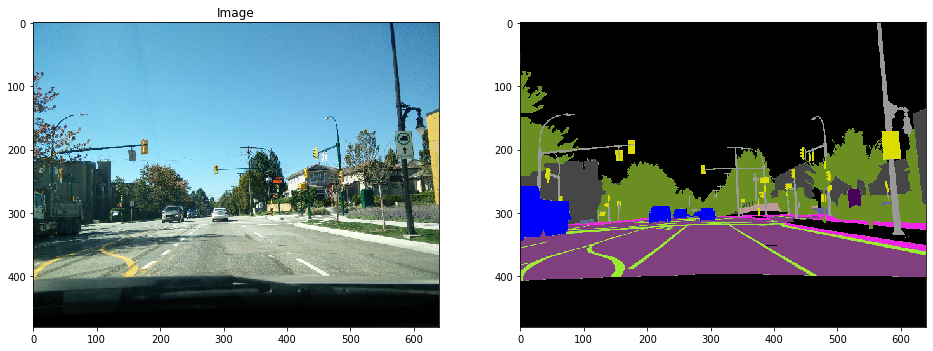

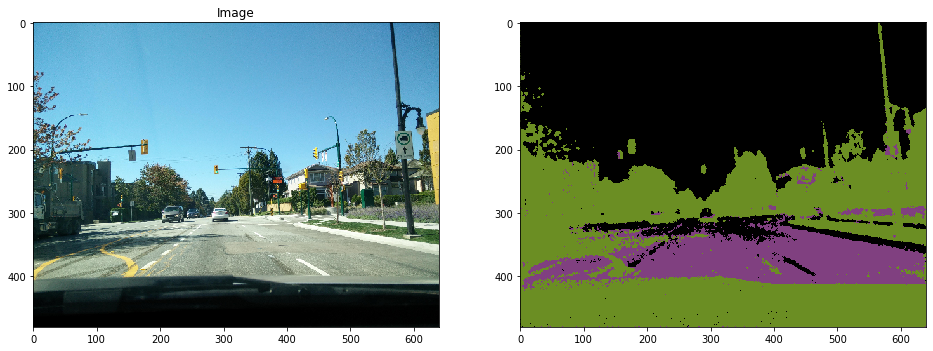

In [7]:
imges, labels = next(batch_generator(img_val_list, color_label_val_list, color_id_map, [30], 1))
model = load_model(f'seg_models/u-net_1585114900.h5')

img_predicted = model.predict(imges)[0]
target = maskes_to_labels(labels[0]).astype(np.uint8)


print(img_predicted.shape)

y_train_label = maskes_to_labels(img_predicted).astype(np.uint8)
compare_img(imges[0], target, 'Image', 'CityScape labels')
compare_img(imges[0], y_train_label, 'Image', 'CityScape labels')




In [8]:
one_model = pixel_score(y=labels[0], y_hat=img_predicted)
print(one_model)
print(iou_score(y=labels[0], y_hat=img_predicted))

0.6202376302083333
0.11167680141539618


(480, 640, 13)
SCORE
Single model score: 0.6202376302083333
Foure model score 0.602802734375


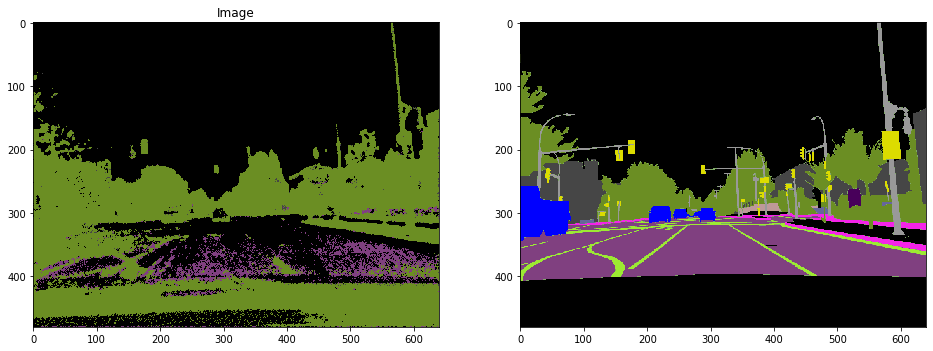

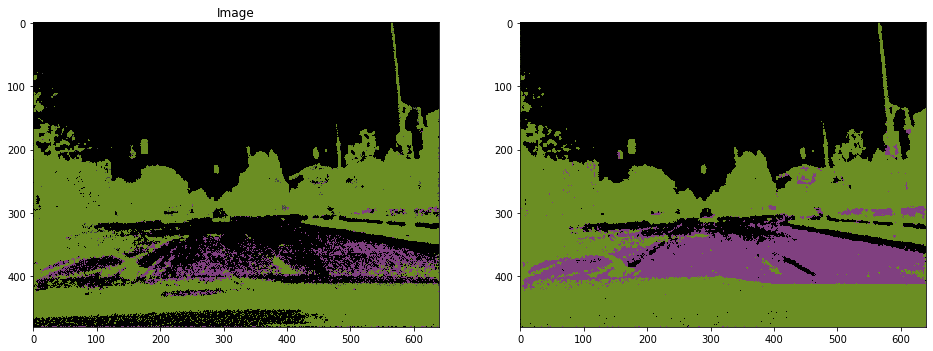

In [9]:
model1 = load_model(f'seg_models/u-net_1585114900.h5')
model2 = load_model(f'seg_models/u-net_1585115750.h5')
model3 = load_model(f'seg_models/u-net_1585248873.h5')
model4 = load_model(f'seg_models/u-net_1585652501.h5')

models = [model1, model2, model3, model4]

predictions = []
for model in models:
    predictions.append(model.predict(imges)[0])

def plurality_voting(predictions):
    prediction = np.zeros((IMG_HEIGHT, IMG_WIDTH, NUM_SEG))
    # prediction_mask = (prediction_probabilities==prediction_probabilities.max(axis=2, keepdims=1)).astype(np.uint8)
    
    for single_pre in predictions:
        prediction += single_pre
    
    prediction = (prediction==prediction.max(axis=2, keepdims=1)).astype(np.uint8)
    
    return prediction    
    
prediction = plurality_voting(predictions)
print(prediction.shape)
pre_label = maskes_to_labels(prediction).astype(np.uint8)
compare_img(pre_label, target, 'Image', 'CityScape labels')
compare_img(pre_label, y_train_label, 'Image', 'CityScape labels')

foure_models = pixel_score(y=labels[0], y_hat=prediction)

print('SCORE')
print(f'Single model score: {one_model}')
print(f'Foure model score {foure_models}')

In [10]:
#output: score of model, mean and std

def ucb1_score(rounds, model_info, c):
    model_round = model_info['round']
    
    if model_round == 0:
        return np.inf
    #print(f'rounds: {model_info["round"]} ,score: {model_info["score"]} time used: {model_info["used_index"]}')
    explotation = model_info['score']
    explortion = math.sqrt(math.log(rounds)/model_round)
    
    return explotation + c*explortion

#calculate old score with new
def calculate_score(rounds, score, old_score):
    return old_score * ((rounds-1)/rounds) + score *(1/rounds)

'''
Endres slik den bruker en dict o stede for key
'''
def try_model(keys, imgs, labels, model_info, round_nr):
    
    y_hats = []
    means = []
    stds = []
    
    old_score_mean = model_info[key]['score']
    old_score_std = model_info[key]['std']
    
    rounds = model_info[key]['round'] + 1
    
    for model_id in keys:
        model = load_model(f'seg_models/{model_id}.h5')
        y_hat, mean, std = predictions_and_uncetrenty(model, 5, imgs) #5
        
        std = np.array(std).mean()
        mean = np.array(mean).mean()
        
        y_hats.append(y_hat)
        means.append(mean)
        stds.append(std)
        
        mean_score = calculate_score(rounds, mean, old_score_mean)
        std_score = calculate_score(rounds, std, old_score_std)
        
        model_info[model_id]['round'] += 1 
        model_info[model_id]['score'] = mean_score
        model_info[model_id]['std'] = std_score
        model_info[model_id]['used_index'].append(round_nr)
        model_info[model_id]['mean_list'].append(mean_score)
    
   
    y_hat = plurality_voting(y_hats)
    mean_avg = np.array(means).mean()
    std_avg = np.array(stds).mean()
    
    
    #print(y_hat.shape)
    score = pixel_score(labels[0], y_hat)
    score_iou = iou_score(labels[0], y_hat)
    
    
   
    return score, score_iou, mean_avg, std_avg


keys = ['u-net_1585114900', 'u-net_1585115750', 'u-net_1585248873', 'u-net_1585652501']

# creates problem with dictonary
'''
score, score_iou, mean, std = try_model(keys, imges, labels, model_info, 1)

print(f'score: {score}')
print(f'IoU score: {score_iou}')
print(f'mean:  {mean}')
print(f'std :  {std}')
'''

"\nscore, score_iou, mean, std = try_model(keys, imges, labels, model_info, 1)\n\nprint(f'score: {score}')\nprint(f'IoU score: {score_iou}')\nprint(f'mean:  {mean}')\nprint(f'std :  {std}')\n"

## Multiarmed Bandit epilon gredy

In [11]:
NUM_MODEL_TEST = 4

key_list = list(model_info.keys())
num_models = len(list(model_info.keys()))
index_list = range(0, len(img_val_list))
num_trials = len(index_list)
gen = batch_generator(img_val_list, color_label_val_list, color_id_map, index_list, 1)
scores = []
iou_scores = []
std_list = []
means = []
score_counter = []
iou_counter = []





'''
MODELS IN USE NEED
- key
- score
- lower bound 
- upper bpund? 

'''
models_in_use = {}
starting_keys = random.sample(key_list, NUM_MODEL_TEST)
best_key = starting_keys[0]

for key in starting_keys:
    models_in_use[key] = model_info[key]
    

'''
Can add matrixes to gather, remove the smalles ass done earlier
innput: (X, 480, 640, 13)
output: (X, 480, 640, 13)
'''

def swich_out_keys(best_key, models, bnn=False):
    
    
    
    #best_score = models[best_key]['score']
    lower_bound = models[best_key]['score'] - np.std(models[best_key]['mean_list'])
    
    worst_key = best_key
    worst_value = lower_bound
    
    swich_out_keys = []
    
    for key, value in models.items():
        
        if bnn:
            std = value['std']
        else:
            std = np.std(value['mean_list'])
       
    if lower_bound > value['score'] + std:
            swich_out_keys.append(key)
    else:
        test_lower_bound = value['score'] - std
        if worst_value > test_lower_bound:
            worst_key = key
            worst_value = test_lower_bound
                
    if len(swich_out_keys) == 0:
        return [worst_key]
            
    return swich_out_keys
    
    



# run bandit thought validation
for i in range(len(index_list)):
    
    
    #print(f'round: {i} of {len(index_list)}')
    imgs, labels = next(gen)
    
    bad_keys = swich_out_keys(best_key, models_in_use) 
    num_new_models = len(bad_keys)
    
    if num_new_models > 0:
        
        #remove the bad models
        for k in bad_keys:
            del models_in_use[k]
        new_model_list_key = random.sample(key_list, num_new_models)
        new_model_list_score = []
        
        #add score for init models
        for key in new_model_list_key:
            new_model_list_score.append(model_info[key]['score'])
        
        # to avoid ading same models to the list
        keys_in_use = models_in_use.keys()
        
        #calculate score and find the right model
        for key, value in model_info.items():
               
            low_score = np.amin(new_model_list_score)
            
            score = ucb1_score(rounds=i, model_info=value, c=0.05) 
            #save some init time
            #check if model is good enough to be used
            if score > low_score and key not in keys_in_use:
                min_index = np.argmin(new_model_list_score)
                new_model_list_key[min_index] = key
                new_model_list_score[min_index] = score
    else:
        print('did not swiche')
    #add new models to model in use
    
    for j in range(num_new_models):
        models_in_use[new_model_list_key[j]] = model_info[new_model_list_key[j]]
        
    
    if best_key not in models_in_use.keys():
        best_key = None
        lower_bound = -np.inf
        
    for key, value in models_in_use.items():
        test_lower_bound = value['score'] - value['std']
        
        if test_lower_bound > lower_bound:
            lower_bound = test_lower_bound
            best_key = key
        
    
    new_score, score_iou, mean, std = try_model(models_in_use.keys(), imgs, labels, model_info, i)


    K.clear_session()
    scores.append(new_score)
    iou_scores.append(score_iou)
    std_list.append(std)
    score_counter.append(new_score)
    iou_counter.append(score_iou)
    means.append(mean)
    #epsilon *= gamma
    
    BATCH_SIZE = 10
    if i % BATCH_SIZE == 0:
        print(f'round: {i} of {len(index_list)}, pixel score: {sum(score_counter) / BATCH_SIZE}, iou score: {sum(iou_counter) / BATCH_SIZE}')
        score_counter = []
        iou_counter = []
        
        


/home/torresrl/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/torresrl/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/torresrl/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


round: 0 of 2000, pixel score: 0.07488704427083334, iou score: 0.01851186108960207
round: 10 of 2000, pixel score: 0.6372145182291666, iou score: 0.12516797218417086
round: 20 of 2000, pixel score: 0.6654576822916667, iou score: 0.13342112494213063
round: 30 of 2000, pixel score: 0.5858740234375, iou score: 0.11700479746594301
round: 40 of 2000, pixel score: 0.5788004557291667, iou score: 0.11253442541906981
round: 50 of 2000, pixel score: 0.6670579427083333, iou score: 0.13098038370576828
round: 60 of 2000, pixel score: 0.5809801432291667, iou score: 0.09762605730443658
round: 70 of 2000, pixel score: 0.6021178385416667, iou score: 0.11349510968459395
round: 80 of 2000, pixel score: 0.6067128906250001, iou score: 0.10566541682985756
round: 90 of 2000, pixel score: 0.5818828125000002, iou score: 0.10202309827248401
round: 100 of 2000, pixel score: 0.48404003906250004, iou score: 0.0965949742759868
round: 110 of 2000, pixel score: 0.5733876953125, iou score: 0.1143408209690758
round: 12

round: 990 of 2000, pixel score: 0.7192021484375, iou score: 0.16794305803483503
round: 1000 of 2000, pixel score: 0.7103020833333333, iou score: 0.15340525641384287
round: 1010 of 2000, pixel score: 0.6827203776041666, iou score: 0.15162864182738206
round: 1020 of 2000, pixel score: 0.7328037109375, iou score: 0.17056433886259564
round: 1030 of 2000, pixel score: 0.7631334635416668, iou score: 0.16246888813871235
round: 1040 of 2000, pixel score: 0.7452669270833333, iou score: 0.17424502301370642
round: 1050 of 2000, pixel score: 0.7841038411458333, iou score: 0.17028681517545377
round: 1060 of 2000, pixel score: 0.7603248697916667, iou score: 0.16964112205563814
round: 1070 of 2000, pixel score: 0.6956669921875, iou score: 0.136909187564125
round: 1080 of 2000, pixel score: 0.7135302734375, iou score: 0.15235442539646404
round: 1090 of 2000, pixel score: 0.6679156901041667, iou score: 0.15070306092882538
round: 1100 of 2000, pixel score: 0.7909231770833334, iou score: 0.1801437618071

round: 1970 of 2000, pixel score: 0.7300019531249999, iou score: 0.1606293744909603
round: 1980 of 2000, pixel score: 0.7458395182291666, iou score: 0.16040902849686822
round: 1990 of 2000, pixel score: 0.7201363932291667, iou score: 0.15658090902411265


 Avg score pr model: 0.5018959926965773


<Figure size 1152x720 with 0 Axes>

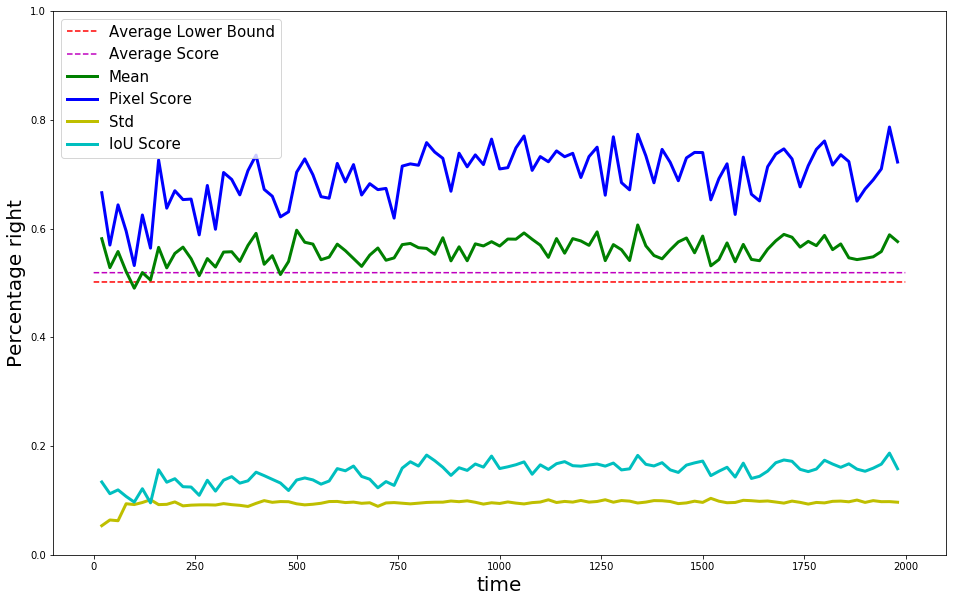

In [12]:
plt.figure(figsize=(16, 10))
score_reduced = []

batch_size = 8



model_score_avg = 0
for key, value in model_info.items():
    model_score_avg += value['score']
model_score_avg = model_score_avg / num_models


#Reduce the list so graph get more general and easyer to read
def generalize_list(scores, batch_size):
    score_batch = []
    score_reduced = []
    x_akses = []
    for i in range(len(scores)):
        if i % batch_size == 0 and i != 0:
            score_reduced.append(sum(score_batch)/batch_size)
            score_batch = []
            x_akses.append(i)
        score_batch.append(scores[i])
    return score_reduced, x_akses

def score_graph(scores, iou_scores, means, std, model_info, batch_size):
    plt.figure(figsize=(16, 10))
    score_reduced = []


    model_score_avg = 0
    for key, value in model_info.items():
        model_score_avg += value['score']
    model_score_avg = model_score_avg / num_models


    # x_akses is the same in both instances
    iou_scores_reduced, _ = generalize_list(iou_scores, batch_size)
    score_reduced, x_akses = generalize_list(scores, batch_size)
    mean_reduced, _ = generalize_list(means, batch_size)
    std_reduced, _ = generalize_list(std, batch_size)
    
    print(f' Avg score pr model: {model_score_avg}')
    avg = np.array([model_score_avg for i in range(num_trials)])
    avg_explore = np.array([0.519 for i in range(num_trials)]) # 0.5186551321699284
    #plt.bar(, y_akses_list)
    plt.ylim(0,1)
    plt.xlabel('time', fontsize=20)
    plt.ylabel('Percentage right', fontsize=20)
    #plt.tick_params(axis='both', which='major', labelsize=18)

    plt.plot(avg, 'r--', label='Average Lower Bound')
    plt.plot(avg_explore, 'm--', label='Average Score')
    plt.plot(x_akses, mean_reduced,'g' ,linewidth=3, label='Mean')
    plt.plot(x_akses, score_reduced,'b' ,linewidth=3, label='Pixel Score')
    plt.plot(x_akses, std_reduced, 'y', linewidth=3, label='Std')
    plt.plot(x_akses, iou_scores_reduced,'c' ,linewidth=3, label='IoU Score')
    plt.legend(loc='best', fontsize=15)
    plt.show()

score_graph(scores, iou_scores, means, std_list, model_info, batch_size=20)

In [13]:

for key, value in model_info.items():
    print(f'Key: {key}, score: {value["score"]} time used: {value["used_index"]}')
    print()

Key: u-net_1585114900, score: 0.5260757207870483 time used: [0]

Key: u-net_1585115750, score: 0.32920899987220764 time used: [1]

Key: u-net_1585116680, score: 0.5836626887321472 time used: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

Key: u-net_1585118770, score: 0.6693069168499536 time used: [3, 166, 167, 168, 169, 170, 171, 172, 173, 198, 208, 243, 258, 309, 534, 535, 536, 537, 548, 549, 729]

Key: u-net_1585123137, score: 0.40602806210517883 time used: [4]

Key: u-net_1585126633, score: 0.5418775081634521 time used: [5, 6, 7]

Key: u-net_1585130481, score: 0.32741579413414 time used: [6]

Key: u-net_1585133766, score: 0.5059168934822083 time used: [7, 8, 9, 10, 11, 12, 13, 14, 15]

Key: u-net_1585136637, score: 0.36393001675605774 time used: [8]

Key: u-net_1585145765, score: 0.38023000955581665 time used: [9]

Key: u-net_1585155175, score: 0.32103583216667175 time used: [10]

Key: u-net_1585164469, score: 0.4967348873615265 time used: [11, 292]

Key: u-net_1585201143, score: 0.2

101


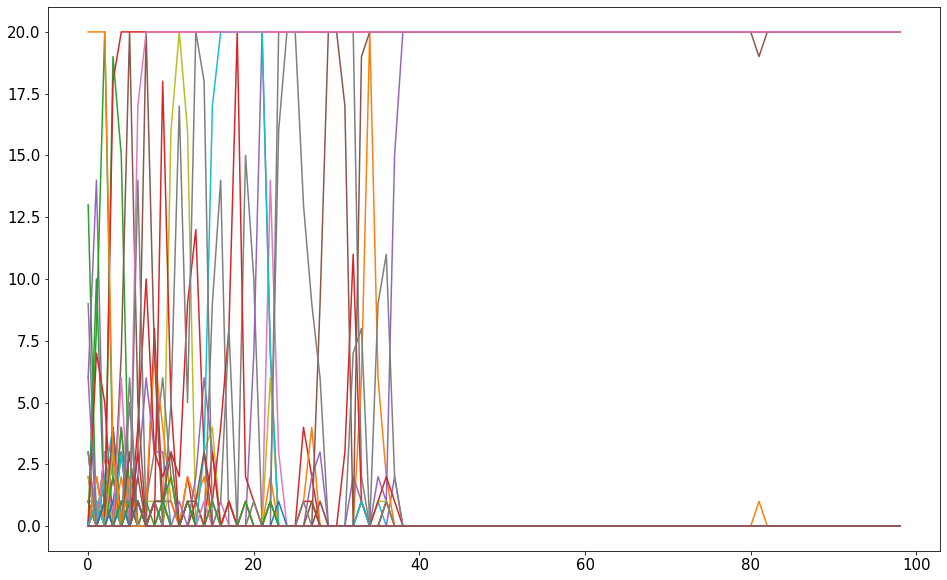

In [14]:

batch_size = 20
model_used = np.zeros((num_models, num_trials), dtype=np.uint8)

smooth = (len(index_list)+batch_size)//batch_size
print(smooth)

counter = 0
for key, value in model_info.items():
    #model_used[counter]
    for index in value['used_index']:
        model_used[counter][index] = 1
    
    counter += 1 

model_used_smoothe = [] #np.zeros((len(key_list), smooth), dtype=np.uint8)
counter = 0
for used in model_used:
    periodic = []
    model_used_smoothe.append([])
    for i in range(len(used)):
        if i % batch_size == 0 and i != 0:
            model_used_smoothe[counter].append(sum(periodic))
            periodic = []
        periodic.append(used[i])
    counter += 1
        

plt.figure(figsize=(16, 10))
plt.tick_params(axis='both', which='major', labelsize=15)
for used_per in model_used_smoothe:
    #print(used_per)
    plt.plot(used_per)
#print(model_used_smoothe[5])
#plt.plot(model_used_smoothe[5])
plt.show()

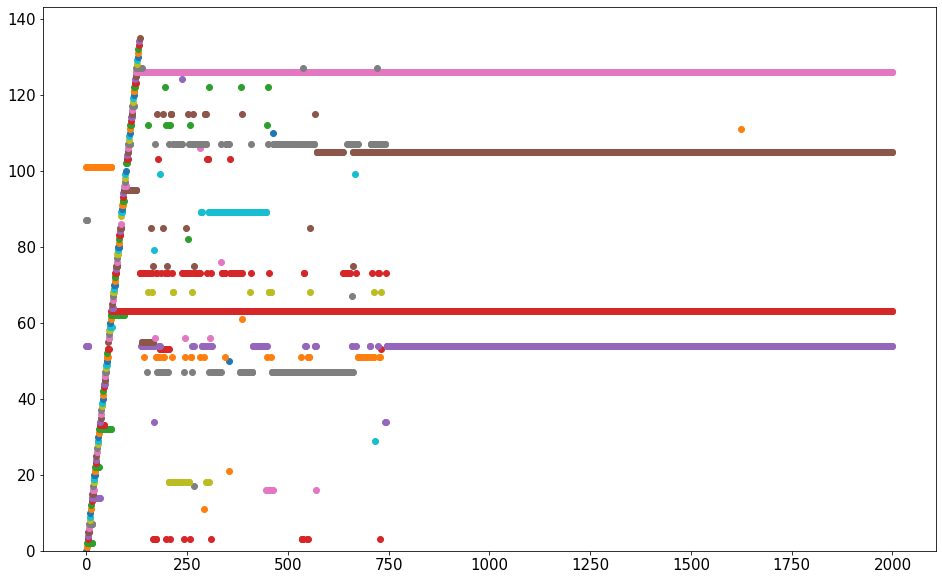

In [15]:

def scatter_model_used(model_info, num_models, num_trials):
    counter = 0
    used_list = []
    
    for _ in range(num_models):
        used_list.append(np.full(num_trials, -10))
    
    for key, value in model_info.items():

        for used in value['used_index']:
            used_list[counter][used] = counter

        counter += 1
        
    counter_list = range(num_trials)
    
    plt.figure(figsize=(16, 10))
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.ylim(0, int(round(num_models * 1.05)))
    for i in range(num_models):
        plt.scatter(counter_list, used_list[i])
    plt.show()
scatter_model_used(model_info, num_models, num_trials)

In [16]:
print('Average ressults')
print(f'pixel score: {np.array(scores).mean()}')
print(f'IoU score : {np.array(iou_scores).mean()}')
print(f'Mean: {np.array(means).mean()}')

Average ressults
pixel score: 0.6963112027994791
IoU score : 0.1516415821669742
Mean: 0.559242308139801


In [17]:
print(models_in_use.keys())

dict_keys(['u-net_1585687310', 'u-net_small_1585914839', 'u-net_1585823364', 'u-net_1585654109'])


In [18]:
print(new_model_list_key)

['u-net_1585654109']
